## Import Libraries

In [15]:
import numpy as np
import pandas as pd
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, NonNegativeReals, SolverFactory
from Utils import homepath


import warnings
warnings.filterwarnings("ignore")

## Risk Parity

In [2]:
def risk_parity_pyomo(returns, asset_classes, asset_class_constraints):
    """
    Computes portfolio weights using Risk Parity with Pyomo, allowing user-defined asset allocation constraints.
    
    Parameters:
        returns (pd.DataFrame): Historical returns of assets.
        asset_classes (dict): Dictionary mapping asset names to their asset class ('stocks', 'bonds', 'deposits').
        asset_class_constraints (dict): User-defined allocation constraints for asset classes, 
                                        e.g., {'stocks': (0.3, 0.7), 'bonds': (0.2, 0.5), 'deposits': (0.1, 0.3)}.

    Returns:
        dict: Optimized portfolio weights.
    """
    # Compute covariance matrix
    Sigma = returns.cov().values
    assets = list(returns.columns)
    num_assets = len(assets)

    # Create Pyomo Model
    model = ConcreteModel()
    
    # Variables: Portfolio Weights (No short-selling allowed)
    model.w = Var(range(num_assets), domain=NonNegativeReals)
    
    # Constraint: Fully Invested Portfolio (sum of weights = 1)
    model.full_investment = Constraint(expr=sum(model.w[i] for i in range(num_assets)) == 1)

    # Portfolio Variance Calculation
    def portfolio_variance(model):
        return sum(model.w[i] * Sigma[i, j] * model.w[j] for i in range(num_assets) for j in range(num_assets))

    # Risk Contribution Calculation
    def risk_contribution(i):
        return model.w[i] * sum(Sigma[i, j] * model.w[j] for j in range(num_assets)) / portfolio_variance(model)

    # Risk Parity Objective: Minimize the standard deviation of risk contributions
    def objective_function(model):
        risk_contributions = [risk_contribution(i) for i in range(num_assets)]
        mean_risk = sum(risk_contributions) / num_assets
        return sum((risk_contributions[i] - mean_risk) ** 2 for i in range(num_assets))
    
    model.objective = Objective(rule=objective_function, sense=1)  # Minimize risk contribution disparity

    # Apply User-Defined Asset Class Constraints
    for asset_class, (lower, upper) in asset_class_constraints.items():
        indices = [i for i, asset in enumerate(assets) if asset_classes[asset] == asset_class]
        if indices:
            model.add_component(f"{asset_class}_min", Constraint(expr=sum(model.w[i] for i in indices) >= lower))
            model.add_component(f"{asset_class}_max", Constraint(expr=sum(model.w[i] for i in indices) <= upper))

    # Solve the Optimization Problem
    solver = SolverFactory('ipopt')
    solver.solve(model, tee=True)

    # Extract Optimized Weights
    weights = {assets[i]: model.w[i].value for i in range(num_assets)}
    return weights


In [3]:
np.random.seed(42)
returns_data = pd.DataFrame(np.random.randn(100, 5) / 100, columns=['AAPL', 'GOOGL', 'TLT', 'IEF', 'CASH'])

# Define asset classes
asset_classes = {
    'AAPL': 'stocks', 
    'GOOGL': 'stocks', 
    'TLT': 'bonds', 
    'IEF': 'bonds', 
    'CASH': 'deposits'
}

# User-Defined Allocation Constraints
asset_class_constraints = {
    'stocks': (0.3, 0.7),   # Stocks allocation between 30% and 70%
    'bonds': (0.2, 0.5),    # Bonds allocation between 20% and 50%
    'deposits': (0.1, 0.3)  # Deposits allocation between 10% and 30%
}

# Compute Optimized Weights
optimal_weights = risk_parity_pyomo(returns_data, asset_classes, asset_class_constraints)
print("\nOptimized Portfolio Weights:", optimal_weights)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:       15

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function c

## GARCH-NAR Risk Parity

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from pyomo.environ import *

# Step 1: Download Data
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "JPM", "SPY"]  # Last one is benchmark
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)["Close"].dropna()

# Step 2: Compute Weekly Log Returns
data_weekly = data.resample('W').last()
log_returns = np.log(data_weekly / data_weekly.shift(1)).dropna()
log_returns_sp500 = log_returns.pop("SPY")  # Benchmark

# Step 3: Forecast Returns & Volatility using GARCH-NAR (Rolling Window)
rolling_window = 104  # 2 years of weekly data
forecasted_returns = pd.DataFrame(index=log_returns.index, columns=log_returns.columns)
forecasted_volatility = pd.DataFrame(index=log_returns.index, columns=log_returns.columns)

for t in range(rolling_window, len(log_returns)):
    train_data = log_returns.iloc[t - rolling_window:t]
    
    for asset in log_returns.columns:
        # GARCH(1,1) Volatility Forecasting
        garch_model = arch_model(train_data[asset], vol='Garch', p=1, q=1, mean='Zero')
        garch_fit = garch_model.fit(disp='off')
        forecasted_volatility.loc[log_returns.index[t], asset] = garch_fit.forecast(horizon=1).variance.iloc[-1, 0]**0.5
        
        # NAR Model (MLP)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(np.arange(len(train_data)).reshape(-1, 1))
        y_train = train_data[asset].values
        
        nar_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
        nar_model.fit(X_train, y_train)
        
        X_test = scaler.transform(np.array([[len(train_data)]]))
        forecasted_returns.loc[log_returns.index[t], asset] = nar_model.predict(X_test)[0]

# Step 4: Risk Parity Optimization (Rebalancing Every 8 Weeks)
rebalance_freq = 8
portfolio_weights = pd.DataFrame(index=log_returns.index, columns=log_returns.columns)

for t in range(rolling_window, len(log_returns), rebalance_freq):
    current_vol = forecasted_volatility.iloc[t].dropna()
    
    model = ConcreteModel()
    model.assets = Set(initialize=current_vol.index)
    model.w = Var(model.assets, domain=NonNegativeReals)
    
    def risk_contribution_rule(model, i):
        return model.w[i] * current_vol[i] == (1 / len(model.assets)) * sum(model.w[j] * current_vol[j] for j in model.assets)
    
    model.risk_parity = Constraint(model.assets, rule=risk_contribution_rule)
    model.total_weight = Constraint(expr=sum(model.w[i] for i in model.assets) == 1)
    model.objective = Objective(expr=0, sense=minimize)  # Dummy objective
    
    solver = SolverFactory('ipopt')
    solver.solve(model)
    
    weights = {i: model.w[i]()/sum(model.w[j]() for j in model.assets) for i in model.assets}
    portfolio_weights.iloc[t] = weights

portfolio_weights.fillna(method='ffill', inplace=True)  # Carry forward last allocation

# Step 5: Compute Strategy Performance
portfolio_returns = (portfolio_weights * log_returns).sum(axis=1)
cumulative_returns = np.exp(portfolio_returns.cumsum()) - 1
cumulative_returns_sp500 = np.exp(log_returns_sp500.cumsum()) - 1

# Step 6: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Risk Parity Strategy')
plt.plot(cumulative_returns_sp500, label='S&P 500', linestyle='dashed')
plt.legend()
plt.title('Cumulative Returns: Risk Parity vs. S&P 500')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
plt.grid()
plt.show()


[*********************100%***********************]  6 of 6 completed
c:\Users\BSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\BSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or 

model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

[*********************100%***********************]  6 of 6 completed
c:\Users\BSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\BSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or 

model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!


c:\Users\BSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unknown";
    - termination condition: other
    - message from solver: Too few degrees of freedom (rethrown)!
model.name="unkn

C:\Users\BSI\AppData\Local\Temp\ipykernel_5416\1150241048.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_weights.fillna(method='ffill', inplace=True)  # Carry forward last allocation
C:\Users\BSI\AppData\Local\Temp\ipykernel_5416\1150241048.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio_weights.fillna(method='ffill', inplace=True)  # Carry forward last allocation


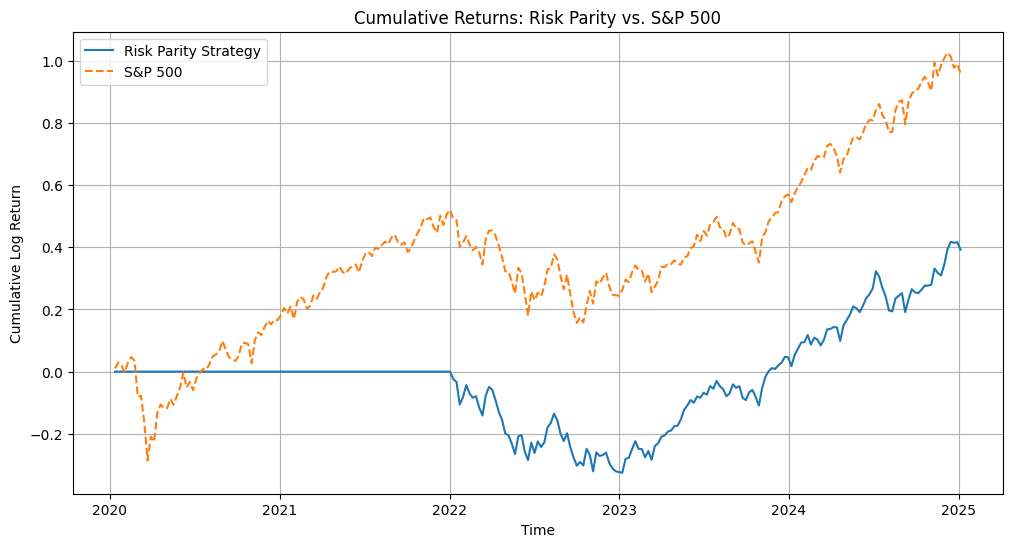

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from pyomo.environ import *

# Step 1: Download Data
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "JPM", "SPY"]  # Last one is benchmark
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)["Close"].dropna()

# Step 2: Compute Weekly Log Returns
data_weekly = data.resample('W').last()
log_returns = np.log(data_weekly / data_weekly.shift(1)).dropna()
log_returns_sp500 = log_returns.pop("SPY")  # Benchmark

# Step 3: Forecast Returns & Volatility using GARCH-NAR (Rolling Window)
rolling_window = 104  # 2 years of weekly data
forecasted_returns = pd.DataFrame(index=log_returns.index, columns=log_returns.columns)
forecasted_volatility = pd.DataFrame(index=log_returns.index, columns=log_returns.columns)

for t in range(rolling_window, len(log_returns)):
    train_data = log_returns.iloc[t - rolling_window:t]
    
    for asset in log_returns.columns:
        # GARCH(1,1) Volatility Forecasting
        garch_model = arch_model(train_data[asset], vol='Garch', p=1, q=1, mean='Zero')
        garch_fit = garch_model.fit(disp='off')
        forecasted_volatility.loc[log_returns.index[t], asset] = garch_fit.forecast(horizon=1).variance.iloc[-1, 0]**0.5
        
        # NAR Model (MLP)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(np.arange(len(train_data)).reshape(-1, 1))
        y_train = train_data[asset].values
        
        nar_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
        nar_model.fit(X_train, y_train)
        
        X_test = scaler.transform(np.array([[len(train_data)]]))
        forecasted_returns.loc[log_returns.index[t], asset] = nar_model.predict(X_test)[0]

# Step 4: Risk Parity Optimization (Rebalancing Every 8 Weeks)
rebalance_freq = 8
portfolio_weights = pd.DataFrame(index=log_returns.index, columns=log_returns.columns)

for t in range(rolling_window, len(log_returns), rebalance_freq):
    current_vol = forecasted_volatility.iloc[t].dropna()
    
    model = ConcreteModel()
    model.assets = Set(initialize=current_vol.index)
    model.w = Var(model.assets, domain=NonNegativeReals)
    
    def risk_contribution_rule(model, i):
        return model.w[i] * current_vol[i] == (1 / len(model.assets)) * sum(model.w[j] * current_vol[j] for j in model.assets)
    
    model.risk_parity = Constraint(model.assets, rule=risk_contribution_rule)
    model.total_weight = Constraint(expr=sum(model.w[i] for i in model.assets) == 1)
    model.objective = Objective(expr=0, sense=minimize)  # Dummy objective
    
    solver = SolverFactory('ipopt')
    solver.solve(model)
    
    weights = {}
    total_weight = sum(model.w[j]() for j in model.assets if model.w[j]() is not None)
    
    if total_weight is not None and total_weight > 0:
        weights = {i: (model.w[i]() / total_weight) if model.w[i]() is not None else 0 for i in model.assets}
    else:
        weights = {i: 1 / len(model.assets) for i in model.assets}  # Equal weights fallback
    
    portfolio_weights.iloc[t] = weights

portfolio_weights.fillna(method='ffill', inplace=True)  # Carry forward last allocation

# Step 5: Compute Strategy Performance
portfolio_returns = (portfolio_weights * log_returns).sum(axis=1)
cumulative_returns = np.exp(portfolio_returns.cumsum()) - 1
cumulative_returns_sp500 = np.exp(log_returns_sp500.cumsum()) - 1

# Step 6: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Risk Parity Strategy')
plt.plot(cumulative_returns_sp500, label='S&P 500', linestyle='dashed')
plt.legend()
plt.title('Cumulative Returns: Risk Parity vs. S&P 500')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
plt.grid()
plt.show()
